## Part II.머신러닝 실무 프로젝트

#### Chapter 7 - PJT 1 : 영화추천 시스템 만들기 

#### [이론적 배경]

1. 추천 시스템에서 주로 사용되는 input data 
- Preference data : 사용자의 선호도 
- Query : 정보탐색을 위해 사용된 검색어 
- Critique : 댓글, 후기, 평가 
- Item feature : 상품 설명, 특성 
- Demographic : 인구통계 정보 
- Context : 사용패턴, 위치정보, 재고현황 등의 맥락 

2. 추천 알고리즘 
- collaborative filtering 
  - 평가경항이 비슷하거나, 비슷한 평가를 받은 아이템들을 찾는 식 
  - 장점 : 예를들어 제목이나 장르 등에 포함된 단어의 유사성이 없어도 시작할 수 있다. 다양한 추천 가능 & 도메인 지식 의존도 낮음 
  - 단점 : 데이터가 충분이 축적되기 전까지 추천이 불가능 하다. (Cold start) 
- content-based filtering 
  - 아이템의 제목, 장르, 특징등에  비슷한 단어나 내용이 들어있는 것들을 찾는 식 
  - 장점 : 누적된 데이터가없는 상황에서도 비교적 적적할 추천이 가능 
  - 단점 : 형태소 분석, dictionary의 유지보수 등 도메인 특화 데이터에 대한 지식과 관리 필요 

### <font color = 'yellow'> 1. Data set 준비 

In [13]:
### 무비렌즈 데이터 다운로드 (http://files.grouplens.org/datasets/movielens/ml-100k.zip)
### 사용자 데이터 형태 확인
import pandas as pd 
u_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('data/u.user', sep='|', names = u_cols)
users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [14]:
### 영화정보 데이터 형태 확인
### u.item은 24개 컬럼을 가졌으며, latin1 형식으로 인코딩 되어있다. 
m_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL']
movies = pd.read_csv('data/u.item', sep='|', names = m_cols, usecols = range(5), encoding = 'latin1')
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [17]:
### 평점 데이터 형태 확인
### date 컬럼은 timestamp 형태로 변환, 컬럼 구분자가 tab으로 되어있음 주의  
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('data/u.data', sep= '\t', names = r_cols)
ratings['date'] = pd.to_datetime(ratings['unix_timestamp'], unit='s')

ratings.head()

,user_id,movie_id,rating,unix_timestamp,date
0,196,242,3,881250949,1997-12-04 15:55:49
1,186,302,3,891717742,1998-04-04 19:22:22
2,22,377,1,878887116,1997-11-07 07:18:36
3,244,51,2,880606923,1997-11-27 05:02:03
4,166,346,1,886397596,1998-02-02 05:33:16


In [18]:
### 평점예측을 위해 movies와 users를 병합한 데이터셋을 생성한다. 
movie_rating = pd.merge(movies, ratings)
lens = pd.merge(movie_rating, users)

lens.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,user_id,rating,unix_timestamp,date,age,gender,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,1998-02-17 17:51:30,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,1998-02-17 18:20:08,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,1998-02-17 18:07:27,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,1998-02-17 17:31:36,60,M,retired,95076


### <font color = 'yellow'> 2. EDA 

In [24]:
### 평점을 가장 많이 받은 영화들을 나열하라 (20개)
lens.movie_title.value_counts()[:20]

Star Wars (1977)                    583
Contact (1997)                      509
Fargo (1996)                        508
Return of the Jedi (1983)           507
Liar Liar (1997)                    485
English Patient, The (1996)         481
Scream (1996)                       478
Toy Story (1995)                    452
Air Force One (1997)                431
Independence Day (ID4) (1996)       429
Raiders of the Lost Ark (1981)      420
Godfather, The (1972)               413
Pulp Fiction (1994)                 394
Twelve Monkeys (1995)               392
Silence of the Lambs, The (1991)    390
Jerry Maguire (1996)                384
Chasing Amy (1997)                  379
Rock, The (1996)                    378
Empire Strikes Back, The (1980)     367
Star Trek: First Contact (1996)     365
Name: movie_title, dtype: int64

- '70~90년대 작품들 위주, 최신영화들은 상대적으로 평가받은 수가 적을 가능성 있다.

In [28]:
### 평점 평균이 높은 순서대로 정렬하라. 
import numpy as np
movie_stats = lens.groupby('movie_title').agg({'rating':[np.size, np.mean]})
movie_stats.sort_values(by = [('rating', 'mean')], ascending = False).head(10)

rating     
                                                    size mean
movie_title                                                  
They Made Me a Criminal (1939)                         1  5.0
Marlene Dietrich: Shadow and Light (1996)              1  5.0
Saint of Fort Washington, The (1993)                   2  5.0
Someone Else's America (1995)                          1  5.0
Star Kid (1997)                                        3  5.0
Great Day in Harlem, A (1994)                          1  5.0
Aiqing wansui (1994)                                   1  5.0
Santa with Muscles (1996)                              2  5.0
Prefontaine (1997)                                     3  5.0
Entertaining Angels: The Dorothy Day Story (1996)      1  5.0

- 높은 평점을 1, 2번 받은 것들이 표시된다. 평가건수가 일정 수 이상인 것만 필터링 하자 

In [30]:
### 평점건수가 100건 이상인 것들만 추린 후, 다시 평점 높은순으로 정렬하라 
atleast_100 = movie_stats['rating']['size'] >= 100 
movie_stats[atleast_100].sort_values(by=[('rating', 'mean')], ascending = False).head(10)

rating          
                                   size      mean
movie_title                                      
Close Shave, A (1995)               112  4.491071
Schindler's List (1993)             298  4.466443
Wrong Trousers, The (1993)          118  4.466102
Casablanca (1942)                   243  4.456790
Shawshank Redemption, The (1994)    283  4.445230
Rear Window (1954)                  209  4.387560
Usual Suspects, The (1995)          267  4.385768
Star Wars (1977)                    583  4.358491
12 Angry Men (1957)                 125  4.344000
Citizen Kane (1941)                 198  4.292929

Text(0, 0.5, 'rating counts by user')

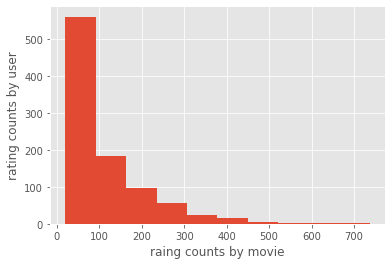

In [36]:
### 사용자별 평가횟수 분포를 살펴보자 
import matplotlib.pyplot as plt 
lens.groupby('user_id').size().sort_values(ascending = False).hist()
plt.xlabel('raing counts by movie')
plt.ylabel('rating counts by user')

In [41]:
### 사용자별 평가횟수와 평균점수를 구하라. 
user_stats = lens.groupby('user_id').agg({'rating':[np.size, np.mean]})
user_stats['rating'].describe()

,size,mean
count,943.000000,943.000000
mean,106.044539,3.588191
std,100.931743,0.445233
min,20.000000,1.491954
25%,33.000000,3.323054
50%,65.000000,3.620690
75%,148.000000,3.869565
max,737.000000,4.869565


- 개인의 평균 별점이 1.49로 매우 짠편 부터 4.86으로 매우 후한 편까지 
- 별점을 주는데 있어서 개인별 성향이 존재하는 듯 

### <font color = 'yellow'> 3. Factorial machine을 이용한 추천시스템 구현 

In [50]:
## fastFM 패키지 설치 
pip install libFM

SyntaxError: invalid syntax (<ipython-input-50-2f35e5788e71>, line 2)

- fastFM은 windows를 지원하지 않아, 실습 중단 